<a href="https://colab.research.google.com/github/msiplab/EicEngLabIV/blob/develop/example02_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実験Ⅳ－２　時系列データの分析

1. サンプルデータの読み込み
1. 平均 $\mu$ と分散 $\gamma_0$ の推定
1. 自己共分散関数 $\gamma_k$ と自己相関関数 $\rho_k$ の推定

新潟大学工学部工学科　電子情報通信プログラム 

## 準備

In [106]:
!pip install bs4
!pip install japanize-matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore') #警告を無視（コメントアウト推奨）

from urllib import request
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import pandas.tseries.offsets as offsets
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib #日本語化matplotlib
sns.set(font="IPAexGothic") #日本語フォント設定

## Webからの水位データの読み込み

新潟県河川防災情報システムより
http://doboku-bousai.pref.niigata.jp/kasen/index.html

以下のPythonライブラリを利用
- urllib
- bs4

In [95]:
# 水位観測所IDの設定
loc = '260' # 小千谷市 ライブ映像 http://www.hrr.mlit.go.jp/shinano/live/map1.html# （11番目付近）

# 解析期間の設定
dts = '2020070100' # 開始日時
dte = '2020072212' # 終了日時
interval = 1 # hour

# Webからの水位情報抽出
dts00 = pd.to_datetime(dts+'00')
dte00 = pd.to_datetime(dte+'00')
td = dte00 - dts00
durationinhours = int(td.total_seconds()/(3600))
t = [ [] for idx in range(durationinhours) ]
y = [ 0.0 for idx in range(durationinhours) ]
idt = dts00
idx = 0
while idt < dte00:
    # 水位抽出日時の設定
    strdt = idt.strftime('%Y%m%d%H%M')
    ts = pd.to_datetime(idt).tz_localize('Asia/Tokyo')

    # URLの設定
    url = 'http://doboku-bousai.pref.niigata.jp/kasen/servlet/bousaiweb.servletBousaiGraph?ga=4&gk=0&gn=0&gl=0&gw=0&go=0&omp=0&opn=0&spn=0&tvm=0&tsw=0&sv=3&dk=2&mp=0&no=0&fn=0&pg=6&sitept=0&unq=12062215494&nwg=0&tmg={0}&sn={1}&wsl=3&wl=1&rg=1&sy=gra_river&psn=0&=&nw=0&tm={0}&logflg=0'.format(strdt,loc)

    # 指定した時刻の水位情報抽出
    response = request.urlopen(url)
    soup = BeautifulSoup(response)
    response.close()
    if idt == dts00:
        strtitle = soup.title.text.strip()
    #print(soup.find('td', class_='tableHeaderCast').text.strip())
    strwaterlevel = soup.find('td', class_='tableHeaderItemCen').text.strip().replace('m','')
    waterlevel = float(strwaterlevel.replace('---','nan'))

    # リストへのデータ登録
    t[idx] = ts
    y[idx] = waterlevel

    # 時間を更新
    idx += 1
    idt += offsets.Hour(interval)


## 時系列データをpandas.DataFrameオブジェクトに変換

pandas ライブラリの DataFrame オブジェクトに変換

- t: 時刻
- y: データの値


In [96]:
df_timeseries= pd.DataFrame({'t': t, 'y': y})
display(df_timeseries)

,t,y
0,2020-07-08 00:00:00+09:00,44.78
1,2020-07-08 01:00:00+09:00,44.80
2,2020-07-08 02:00:00+09:00,44.82
3,2020-07-08 03:00:00+09:00,44.83
4,2020-07-08 04:00:00+09:00,44.91
...,...,...
175,2020-07-15 07:00:00+09:00,44.57
176,2020-07-15 08:00:00+09:00,44.69
177,2020-07-15 09:00:00+09:00,44.71
178,2020-07-15 10:00:00+09:00,44.66


## 時系列データをプロット

- y: 原系列
- y_fillna: 欠損個所を前の値で補間


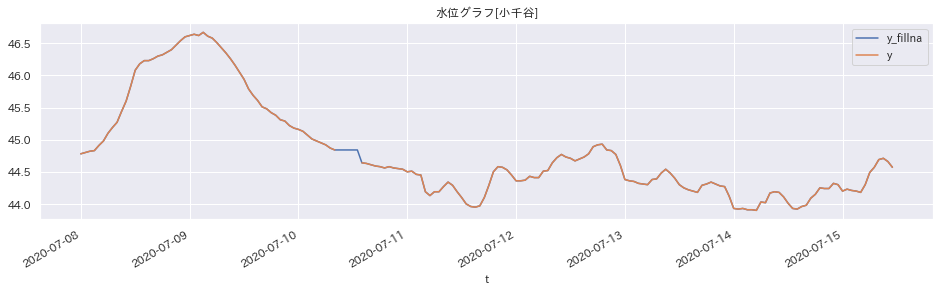

In [97]:
df_timeseries['y_fillna'] = df_timeseries['y'].fillna(method='ffill').astype(float) 
ax = df_timeseries.plot(x='t', y={'y', 'y_fillna'}, figsize=(16,4), title=strtitle)


ヒストグラムをプロット

Text(0.5, 1.0, '水位グラフ[小千谷]')

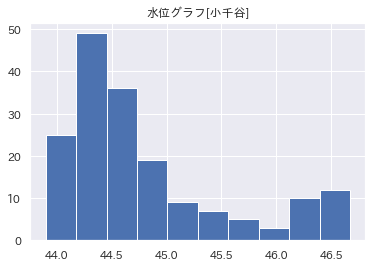

In [98]:
ax = df_timeseries.hist('y')
ax[0][0].set_title(strtitle)

## 平均 $\mu$ と分散 $\gamma_0$ の推定

- mean(): 標本平均を計算
- var(): 標本分散を計算

pandas.DataFrame オブジェクトのvar() メソッドのオプションで 

- ddof = 0 とすると N で割る最尤推定
- ddof = 1 とすると (N-1)で割る不偏推定 ※デフォルト

In [99]:
y_series = df_timeseries['y']
mu = y_series.mean()
gamma0 = y_series.var(ddof=1) 
print('平均 = {:f}, 分散 = {:f}'.format(mu,gamma0))

平均 = 44.801600, 分散 = 0.584833


## 自己共分散関数 $\gamma_k$ と自己相関関数 $\rho_k$ の推定

y_series は pandas.Series のオブジェクトとなっている。
pandas.Seriesオブジェクトは以下のメソッドを備える。

- cov() は共分散の不偏推定を計算
- corr() は相関の不偏推定を計算

※不偏推定から最尤推定への切替はできない


In [100]:
nlags = 40
for lag in range(nlags+1):
    gammak = y_series.cov(y_series.shift(lag))
    rhok = y_series.corr(y_series.shift(lag))
    print('γ{0:d} = {1:f}, ρ{0:d} = {2:f}'.format(lag,gammak,rhok))

γ0 = 0.584833, ρ0 = 1.000000
γ1 = 0.588214, ρ1 = 0.994622
γ2 = 0.587701, ρ2 = 0.982465
γ3 = 0.584322, ρ3 = 0.965610
γ4 = 0.579162, ρ4 = 0.946067
γ5 = 0.573038, ρ5 = 0.925457
γ6 = 0.563153, ρ6 = 0.904852
γ7 = 0.553244, ρ7 = 0.885345
γ8 = 0.542757, ρ8 = 0.866010
γ9 = 0.531485, ρ9 = 0.845750
γ10 = 0.519082, ρ10 = 0.824546
γ11 = 0.505147, ρ11 = 0.801966
γ12 = 0.488797, ρ12 = 0.777576
γ13 = 0.470549, ρ13 = 0.752002
γ14 = 0.450397, ρ14 = 0.724453
γ15 = 0.429026, ρ15 = 0.696580
γ16 = 0.407332, ρ16 = 0.668215
γ17 = 0.385886, ρ17 = 0.639875
γ18 = 0.365197, ρ18 = 0.613596
γ19 = 0.345808, ρ19 = 0.589462
γ20 = 0.327397, ρ20 = 0.567057
γ21 = 0.309459, ρ21 = 0.546263
γ22 = 0.291386, ρ22 = 0.527018
γ23 = 0.272881, ρ23 = 0.507999
γ24 = 0.253580, ρ24 = 0.488323
γ25 = 0.232615, ρ25 = 0.464936
γ26 = 0.211426, ρ26 = 0.439655
γ27 = 0.190842, ρ27 = 0.413521
γ28 = 0.171648, ρ28 = 0.388799
γ29 = 0.154622, ρ29 = 0.365825
γ30 = 0.140116, ρ30 = 0.346627
γ31 = 0.128305, ρ31 = 0.331847
γ32 = 0.118363, ρ32 = 0.3200

## 時系列解析ライブラリ

時系列解析には，statsmodelsライブラリも利用できる。

- acovf() は自己共分散関数を計算
- acf() は自己相関関数を計算

各メソッドのオプション unbiased = True で不偏推定，Falseで最尤推定となる．



In [101]:
import statsmodels.api as sm
from statsmodels.tsa import stattools

#欠損値がある場合は nan が含まれる．
#欠損個所を補間したデータを使わない場合は以下の行をコメントアウトする
y_series = df_timeseries['y_fillna']

print('自己共分散関数')
y_acovf = stattools.acovf(y_series,unbiased=True)
display(y_acovf)
print('自己相関関数')
y_acf = stattools.acf(y_series,unbiased=True)
display(y_acf)


自己共分散関数


array([ 5.65378444e-01,  5.65216459e-01,  5.61263291e-01,  5.54562554e-01,
        5.46184384e-01,  5.36930997e-01,  5.27486038e-01,  5.18034279e-01,
        5.08040755e-01,  4.97307345e-01,  4.85496366e-01,  4.72230701e-01,
        4.56672786e-01,  4.39291622e-01,  4.20120444e-01,  3.99753980e-01,
        3.79076339e-01,  3.58593491e-01,  3.38799992e-01,  3.20167401e-01,
        3.02388861e-01,  2.85040486e-01,  2.67538208e-01,  2.49585667e-01,
        2.30925872e-01,  2.10769305e-01,  1.90365509e-01,  1.70474562e-01,
        1.51733602e-01,  1.34646007e-01,  1.19730222e-01,  1.06754270e-01,
        9.52422462e-02,  8.44911927e-02,  7.41676134e-02,  6.38216858e-02,
        5.29559074e-02,  4.16997918e-02,  2.99288013e-02,  1.79664492e-02,
        6.39653968e-03, -4.38291287e-03, -1.38726473e-02, -2.17915264e-02,
       -2.87018595e-02, -3.50244444e-02, -4.11555755e-02, -4.77691796e-02,
       -5.52426364e-02, -6.41216930e-02, -7.31863248e-02, -8.15728889e-02,
       -8.89695556e-02, -

自己相関関数


array([1.        , 0.99971349, 0.99272142, 0.98086964, 0.96605095,
       0.94968424, 0.93297869, 0.91626111, 0.89858529, 0.87960082,
       0.85871043, 0.83524709, 0.80772939, 0.77698686, 0.74307828,
       0.70705557, 0.67048248, 0.63425391, 0.59924462, 0.56628866,
       0.53484328, 0.50415874, 0.473202  , 0.44144886, 0.40844478,
       0.37279332, 0.33670458, 0.30152292, 0.26837529, 0.238152  ,
       0.21177005, 0.18881914, 0.16845751, 0.14944184, 0.13118224,
       0.11288313, 0.09366453, 0.07375554, 0.05293587, 0.03177774,
       0.01131373])

## 原系列のコレログラムの表示

自己相関のグラフをコレログラムとよぶ。コレログラムは次のコマンドで表示できる。

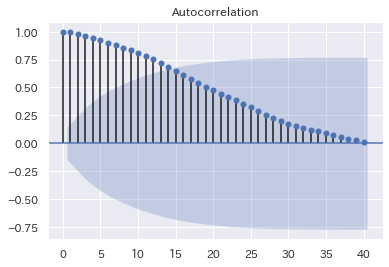

In [102]:
fig = sm.graphics.tsa.plot_acf(y_series,lags=nlags)

## 階差系列の分析

ひとつ前の値との差分をとった系列を階差系列とよぶ。

$\Delta y_n = y_{n} - y_{n-1}$


,t,y,y_fillna,y_diff
0,2020-07-08 00:00:00+09:00,44.78,44.78,NaN
1,2020-07-08 01:00:00+09:00,44.80,44.80,0.02
2,2020-07-08 02:00:00+09:00,44.82,44.82,0.02
3,2020-07-08 03:00:00+09:00,44.83,44.83,0.01
4,2020-07-08 04:00:00+09:00,44.91,44.91,0.08
...,...,...,...,...
175,2020-07-15 07:00:00+09:00,44.57,44.57,0.08
176,2020-07-15 08:00:00+09:00,44.69,44.69,0.12
177,2020-07-15 09:00:00+09:00,44.71,44.71,0.02
178,2020-07-15 10:00:00+09:00,44.66,44.66,-0.05


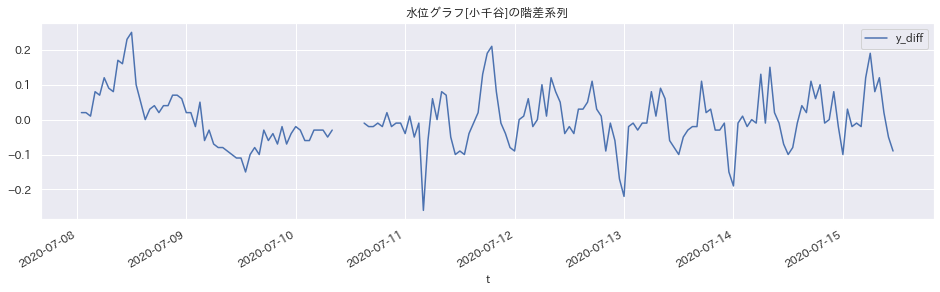

In [103]:
# 欠損データの補間を行わない場合
#df_timeseries['y_diff'] = df_timeseries['y'].diff()
# 欠損データを補間を行う場合
df_timeseries['y_diff'] = df_timeseries['y_fillna'].diff()
display(df_timeseries)
df_timeseries.plot(x='t', y='y_diff', figsize=(16,4), title='{}の階差系列'.format(strtitle))



ヒストグラムをプロット


Text(0.5, 1.0, '水位グラフ[小千谷]')

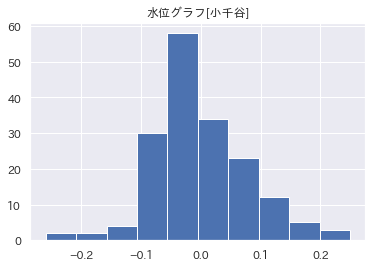

In [104]:
ax = df_timeseries.hist('y_diff')
ax[0][0].set_title(strtitle)

原系列 $y_n$ と階差系列 $\Delta y_n$ のCSVへの出力

In [105]:
#df_timeseries.to_csv('./data/sample02_03.csv',index=False)